#1. Importando Bibliotecas

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

##1.2. Carregar os dados

In [102]:
df_games = pd.read_csv('vgsales.csv')

##1.3. Criando um relatório detalhado de valores ausentes

In [103]:
report_nas = pd.DataFrame({
    'Total NAs': df_games.isna().sum(),
    'Porcentagem (%)': (df_games.isna().sum() / len(df_games)) * 100}).round(2).sort_values(by='Total NAs', ascending=False)
print("Relatório de Dados Ausentes:")
display(report_nas[report_nas['Total NAs'] > 0])

Relatório de Dados Ausentes:


,Total NAs,Porcentagem (%)
Year,271,1.63
Publisher,58,0.35


##1.4. Tratamento de dados

In [104]:
df_games['Publisher'] = df_games['Publisher'].fillna('Unknown')
df_games = df_games.sort_values('Rank')
df_games['Year'] = df_games['Year'].ffill().bfill().astype(int)

# 2. Criando a conexão interna usando o sqlit3

In [105]:
conn = sqlite3.connect('projeto_games.db')
df_games.to_sql('vendas_games', conn, if_exists='replace', index=False)

16598

#3. Análise 1: Evolução Temporal

In [106]:
query_evolucao = "SELECT Year, SUM(Global_Sales) as Vendas FROM vendas_games GROUP BY Year ORDER BY Year"
df_analise = pd.read_sql(query_evolucao, conn)

##3.1. Criação do grafico "Evolução Global de Vendas de Jogos"

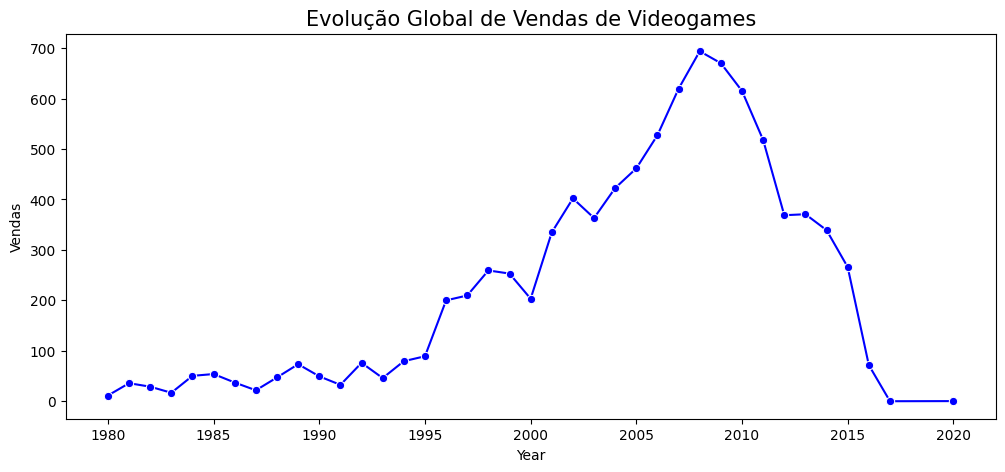

In [107]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_analise, x='Year', y='Vendas', marker='o', color='b')
plt.title('Evolução Global de Vendas de Videogames', fontsize=15)
plt.show()

###**3.1.1 Panorama Geral do Mercado (2001 - 2015)**
Antes de aprofundarmos a disputa entre fabricantes, é necessário entender o comportamento da indústria como um todo. Este gráfico de série temporal ilustra o Volume Total de Software Vendido globalmente.

**Objetivo:** Identificar os períodos de pico e contração do mercado, servindo de contexto para as análises de crescimento individual de cada marca.

#4. Agregação e Categorização via SQL

In [108]:
# --- ANÁLISE 2: Guerra dos Consoles (Normalização) ---
query_comparacao = """
SELECT
    Year,
    CASE
        WHEN Platform IN ('PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV') THEN 'Sony'
        WHEN Platform IN ('Wii', 'NES', 'GB', 'DS', 'SNES', 'GBA', '3DS', 'N64', 'GC', 'WiiU') THEN 'Nintendo'
        WHEN Platform IN ('X360', 'XB', 'XOne') THEN 'Microsoft'
    END AS Fabricante,
    SUM(Global_Sales) AS Vendas
FROM vendas_games
WHERE Year BETWEEN 2001 AND 2015
GROUP BY Year, Fabricante
"""

##4.1. Normalização de Performance por Base Comum

In [109]:
df_raw = pd.read_sql(query_comparacao, conn)
df_pivot = df_raw.pivot(index='Year', columns='Fabricante', values='Vendas')
df_norm = df_pivot.div(df_pivot.iloc[0])

##4.2. Criação de Gráfico com Normalização por Base Comum

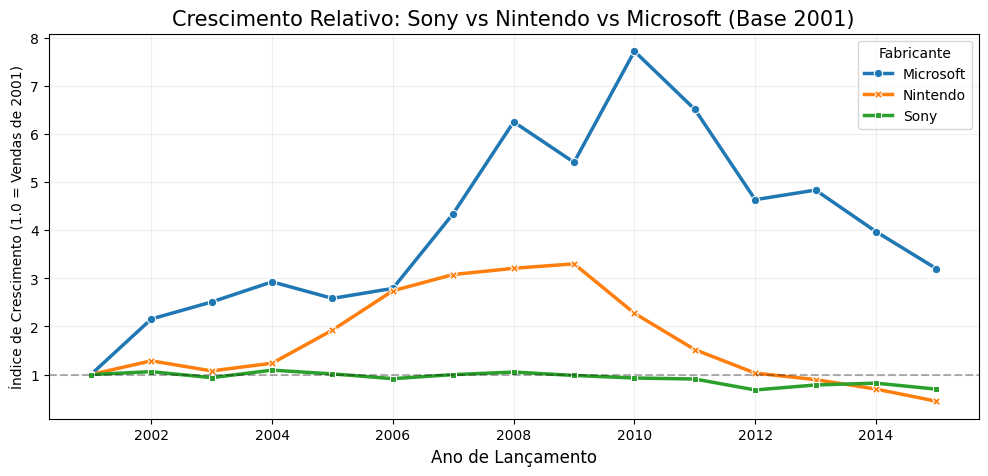

In [110]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_norm, markers=True, dashes=False, linewidth=2.5)

# Título Principal
plt.title('Crescimento Relativo: Sony vs Nintendo vs Microsoft (Base 2001)', fontsize=15)

# Ajustando o Eixo Y (A informação que faltava)
plt.ylabel('Índice de Crescimento (1.0 = Vendas de 2001)', fontsize=10)

# Ajustando o Eixo X (Mesmo sendo o índice, é bom nomear)
plt.xlabel('Ano de Lançamento', fontsize=12)

# Uma linha de referência no 1.0 ajuda a ver quem caiu ou subiu em relação ao início
plt.axhline(1, color='black', linestyle='--', alpha=0.3)

plt.grid(True, alpha=0.2)
plt.show()

###4.2.1 **Análise de Expansão Relativa (Índice Base 1.0)**
Aqui observamos um cenário diferente: a Microsoft apresenta a maior aceleração no índice de crescimento proporcional ao longo do período.

Por que isso acontece? Embora todas as fabricantes comecem o gráfico no ponto 1.0 (o que equaliza a comparação), o valor absoluto de vendas da Microsoft em 2001 era o menor entre as três.

O efeito da Escala: Como o volume inicial da Microsoft era menor, cada novo ciclo de vendas bem-sucedido causou um impacto percentual muito mais agressivo no seu crescimento acumulado.

Em contraste: A Sony e a Nintendo, que já possuíam volumes de vendas massivos em 2001, precisariam vender quantidades astronômicas para mover o seu índice na mesma proporção que a Microsoft.

Conclusão: Este gráfico prova que a Microsoft teve a expansão mais veloz da sua própria base de usuários/vendas, consolidando-se como a marca que mais ganhou tração proporcional no mercado em relação ao seu tamanho inicial.

#5. Executando a Query para obter os dados

In [111]:
query_barras = """
SELECT
    CASE
        WHEN Platform IN ('PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV') THEN 'Sony'
        WHEN Platform IN ('Wii', 'NES', 'GB', 'DS', 'SNES', 'GBA', '3DS', 'N64', 'GC', 'WiiU') THEN 'Nintendo'
        WHEN Platform IN ('X360', 'XB', 'XOne') THEN 'Microsoft'
    END AS Fabricante,
    SUM(Global_Sales) AS Vendas_Totais
FROM vendas_games
WHERE Year BETWEEN 2001 AND 2015
AND Fabricante IS NOT NULL
GROUP BY Fabricante
ORDER BY Vendas_Totais DESC;
"""

df_total = pd.read_sql(query_barras, conn)

##5.1. Criando Gráfico de Barras

/tmp/ipython-input-1565858452.py:1: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(


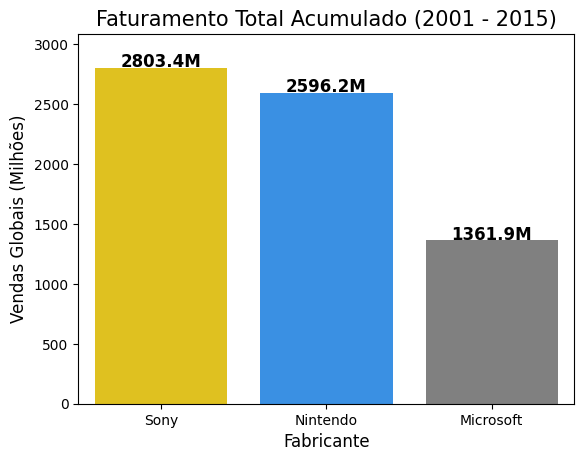

In [112]:
sns.barplot(
    data=df_total,
    x='Fabricante',
    y='Vendas_Totais',
    hue='Fabricante',
    palette=cores,
    legend=False)
for i, valor in enumerate(df_total['Vendas_Totais']):
    plt.text(i, valor + 10, f'{valor:.1f}M', ha='center', fontsize=12, fontweight='bold')

plt.title('Faturamento Total Acumulado (2001 - 2015)', fontsize=15)
plt.ylabel('Vendas Globais (Milhões)', fontsize=12)
plt.xlabel('Fabricante', fontsize=12)
plt.ylim(0, df_total['Vendas_Totais'].max() * 1.1)

plt.show();


###5.1.1 **Análise de Market Share Absoluto**
Este gráfico revela a hierarquia de faturamento no período acumulado. Observamos que a Nintendo e a Sony disputam a liderança em volume total de vendas, enquanto a Microsoft apresenta o menor volume acumulado entre as três.

Insight: Em termos de dinheiro total injetado no mercado, as gigantes japonesas (Sony/Nintendo) ainda dominam o histórico consolidado de vendas de software.

#6. Análise 3: Distribuição Científica

In [113]:
df_games['Status_Venda'] = np.where(
    df_games['Global_Sales'] >= 10, 'Super Hit',
    np.where(df_games['Global_Sales'] >= 5, 'Sucesso Comercial',
    np.where(df_games['Global_Sales'] >= 1, 'Desempenho Padrão', 'Abaixo da Média')))

##6.1. Calculando as Proporções

In [114]:
distribuicao = df_games['Status_Venda'].value_counts(normalize=True) * 100

##6.2. Criando o visual de barras horizontais

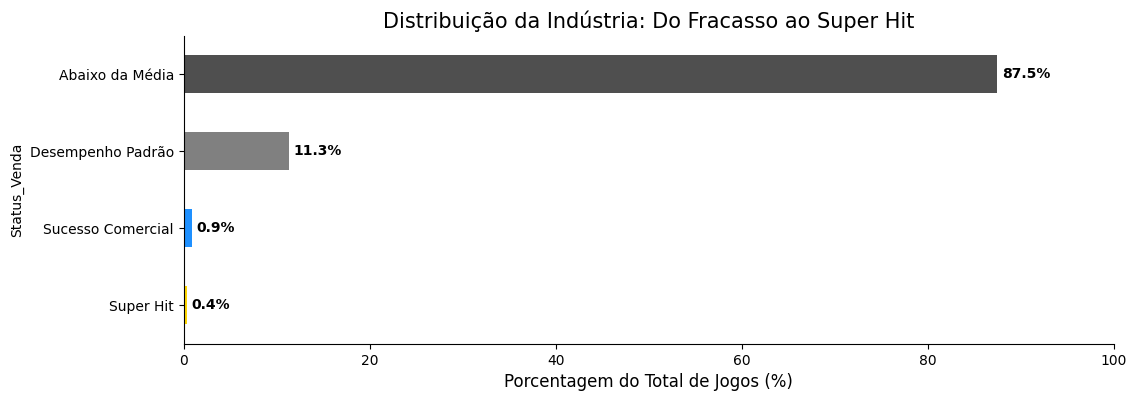

In [115]:
plt.figure(figsize=(12, 4))
cores = ['#FFD700','#1E90FF','#808080','#4F4F4F']
distribuicao.sort_values().plot(kind='barh', color=cores)
for i, valor in enumerate(distribuicao.sort_values()):
    plt.text(valor + 0.5, i, f'{valor:.1f}%', va='center', fontweight='bold')

plt.title('Distribuição da Indústria: Do Fracasso ao Super Hit', fontsize=15)
plt.xlabel('Porcentagem do Total de Jogos (%)', fontsize=12)
plt.xlim(0, 100)
sns.despine()
plt.show()


###**6.2.1 Perfil de Sucesso Comercial na Indústria**
Nesta análise, categorizamos os jogos pelo seu volume de vendas para entender a composição do mercado.
Para entender a distribuição de sucesso na indústria, aplicamos uma lógica de discretização de variáveis contínuas utilizando a biblioteca NumPy. O objetivo é classificar os títulos de acordo com seu impacto comercial global.

Para definir as faixas, utilizamos como referência os marcos de sucesso histórico da indústria:

**Super Hit (Maior ou igual à 10M):** Títulos que definem gerações e impulsionam a venda de consoles (System Sellers).

**Sucesso Comercial (5M à 10M):** Jogos de alto orçamento (AAA) com retorno financeiro consolidado.

**Médio Desempenho (1M à 5M):** Títulos que atingiram seu público-alvo, mas não se tornaram fenômenos globais.

**Baixo Desempenho ( Menor que 1M):** A "Cauda Longa" do mercado, composta por jogos de nicho ou projetos que não alcançaram escala comercial.
*Nota Técnica:* A utilização do np.where permite uma vetorização eficiente desta lógica condicional, garantindo performance superior ao processar grandes volumes de dados no DataFrame.

**Por que isso é "científico?**
Justificativa dos Marcos: Você explica que 1M, 5M e 10M não são aleatórios, são marcos de sucesso na indústria de games.


#**5.Análise Estratégica: Maturidade vs. Expansão**
O fenômeno observado nos dados reflete a dinâmica competitiva do setor:

**Barreira de Crescimento:** Fabricantes como Nintendo e Sony, por já possuírem um mercado consolidado (monopolizado em certos nichos) antes de 2001, enfrentam uma curva de crescimento mais estável. Manter taxas de expansão agressivas é um desafio logístico e de mercado quando você já detém a maioria dos consumidores ativos.

**Oportunidade do Desafiante:** A Microsoft utilizou o período de 2001 a 2015 para realizar uma 'quebra de monopólio'. Partindo de uma base instalada menor, sua velocidade de penetração de mercado foi superior, capturando novos consumidores e expandindo sua relevância proporcional de forma muito mais acelerada que as concorrentes.